In [3]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StandardScaler, VectorAssembler
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

spark = SparkSession \
        .builder \
        .master('spark://10.10.28.172:7077') \
        .appName('visualizing') \
        .enableHiveSupport() \
        .getOrCreate()

spark.sql('use twitter_data')
spark.sql('show tables').show()

22/04/15 12:22:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/15 12:22:16 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
22/04/15 12:22:16 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
22/04/15 12:22:21 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


+------------+--------------------+-----------+
|    database|           tableName|isTemporary|
+------------+--------------------+-----------+
|twitter_data|      processed_data|      false|
|twitter_data|            raw_data|      false|
|twitter_data|             results|      false|
|twitter_data|temp_sentiment_re...|      false|
|twitter_data|    textblob_results|      false|
|twitter_data|       vader_results|      false|
|twitter_data|wordlist2477_results|      false|
+------------+--------------------+-----------+



In [4]:
query = '''
    SELECT created_at, vader_sentiment, textblob_sentiment, wordlist2477_sentiment
    FROM results
'''
df = spark.sql(query)
df.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- vader_sentiment: float (nullable = true)
 |-- textblob_sentiment: float (nullable = true)
 |-- wordlist2477_sentiment: integer (nullable = true)



RESULTS FROM VADER AND TEXTBLOB

<AxesSubplot:xlabel='interval'>

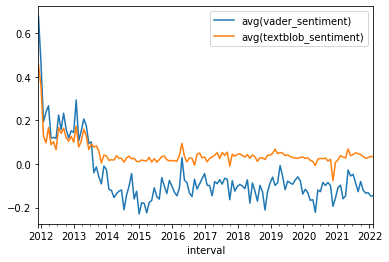

In [5]:
interval = '4 week'
sentiment_results_to_plot = ['vader_sentiment', 'textblob_sentiment']

cols = ['created_at'] + sentiment_results_to_plot
results = df. \
    select(cols). \
    groupBy(F.window('created_at', interval)). \
    mean()

results. \
    withColumn('window', F.col('window').start). \
    sort('window', ascending=True). \
    withColumnRenamed('window', 'interval'). \
    toPandas(). \
    set_index('interval'). \
    plot()

RESULTS FROM WORDLIST2477 (NOT YET NORMALIZED TO -1, +1. SO IT WONT MAKE SENSE TO PLOT ON THE SAME PLOT AS VADER/TB)

<AxesSubplot:xlabel='interval'>

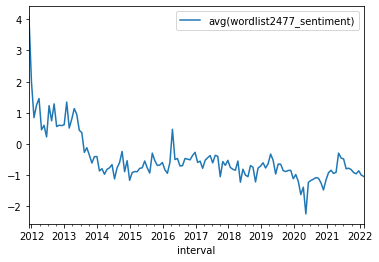

In [6]:
interval = '4 week'
sentiment_results_to_plot = ['wordlist2477_sentiment']

cols = ['created_at'] + sentiment_results_to_plot
results = df. \
    select(cols). \
    groupBy(F.window('created_at', interval)). \
    mean()

results. \
    withColumn('window', F.col('window').start). \
    sort('window', ascending=True). \
    withColumnRenamed('window', 'interval'). \
    toPandas(). \
    set_index('interval'). \
    plot()

### Standard Scaling of Sentiment Scores

In [7]:
sentiment_cols = [x for x, datatype in df.dtypes if datatype != 'timestamp']

vector_asse = VectorAssembler(inputCols=sentiment_cols, outputCol='sentiment_combined')
temp_df = vector_asse.transform(df)

scaler = StandardScaler(inputCol='sentiment_combined', outputCol='scaled_sentiment')
df = scaler.fit(temp_df).transform(temp_df)

# Function just to convert to help build data frame
col_names = ['vader_sentiment','textblob_sentiment','wordlist2477_sentiment','created_at']

def extract(row):
  return row.scaled_sentiment.toArray().tolist() + [row.created_at]

scaled_df = df.select(['created_at','scaled_sentiment']).rdd.map(extract).toDF(col_names)
scaled_df.show(5)

+------------------+------------------+----------------------+-------------------+
|   vader_sentiment|textblob_sentiment|wordlist2477_sentiment|         created_at|
+------------------+------------------+----------------------+-------------------+
|1.8377782057539191| 2.216725609176113|    2.1158391281867646|2012-01-01 11:10:57|
|1.8377782057539191| 2.216725609176113|    2.1158391281867646|2012-01-01 11:11:45|
|1.8377782057539191| 2.216725609176113|    2.1158391281867646|2012-01-01 11:14:03|
|1.8377782057539191| 2.216725609176113|    2.1158391281867646|2012-01-01 11:14:35|
|1.8377782057539191| 2.216725609176113|    2.1158391281867646|2012-01-01 16:03:31|
+------------------+------------------+----------------------+-------------------+
only showing top 5 rows



### Monthly Average Plot of Sentiment Scores

<AxesSubplot:xlabel='interval'>

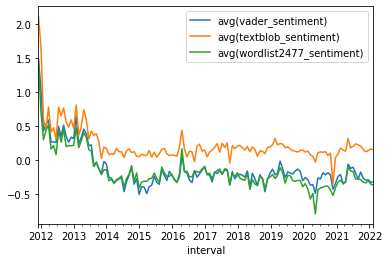

In [8]:
interval = '4 week'
sentiment_results_to_plot = ['vader_sentiment', 'textblob_sentiment','wordlist2477_sentiment']

cols = ['created_at'] + sentiment_results_to_plot
results = scaled_df. \
    select(cols). \
    groupBy(F.window('created_at', interval)). \
    mean()

results. \
    withColumn('window', F.col('window').start). \
    sort('window', ascending=True). \
    withColumnRenamed('window', 'interval'). \
    toPandas(). \
    set_index('interval'). \
    plot()

## Focus on Major Events in The Conflict

### Annexation of Crimea 2014-02-22

In [9]:
start_date = "2014-02-01 00:00:00"
end_date = "2014-02-26 00:00:00"

query = """CAST(created_at AS INT)
        BETWEEN unix_timestamp('{0}', 'yyyy-MM-dd HH:mm:ss')
        AND unix_timestamp('{1}', 'yyyy-MM-dd HH:mm:ss')""".format(start_date, end_date)

crimea_df = scaled_df.where(query)

<AxesSubplot:xlabel='interval'>

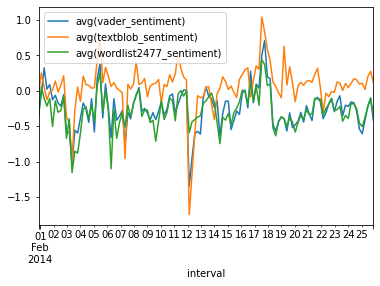

In [10]:
interval = '5 hour'
sentiment_results_to_plot = ['vader_sentiment', 'textblob_sentiment','wordlist2477_sentiment']

cols = ['created_at'] + sentiment_results_to_plot
results = crimea_df. \
    select(cols). \
    groupBy(F.window('created_at', interval)). \
    mean()

results. \
    withColumn('window', F.col('window').start). \
    sort('window', ascending=True). \
    withColumnRenamed('window', 'interval'). \
    toPandas(). \
    set_index('interval'). \
    plot()

### April 2014-04-12 Donbas Conflict Begins in Donetsk

In [11]:
# TODO Add graph

### April 2014-04-13 Counter Offencive Started by Ukraine

In [12]:
# TODO Add Graph

### April 2014-04-15 Ukrainian Parlament decleares Crimea as Occupied by Russia.

In [13]:
# TODO Add graph

### May 2014-05-04 Flag of Donetsk People's Rebulic Raised Over Police Station in Donetsk

In [14]:
# TODO add graph

### November 2014-11-07 -> 2014-11-12 escalation

<AxesSubplot:xlabel='interval'>

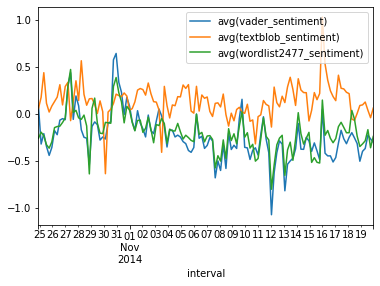

In [15]:
start_date = "2014-10-25 00:00:00"
end_date = "2014-11-20 00:00:00"

query = """CAST(created_at AS INT)
        BETWEEN unix_timestamp('{0}', 'yyyy-MM-dd HH:mm:ss')
        AND unix_timestamp('{1}', 'yyyy-MM-dd HH:mm:ss')""".format(start_date,end_date)

crimea_df = scaled_df.where(query)

interval = '5 hour'
sentiment_results_to_plot = ['vader_sentiment', 'textblob_sentiment','wordlist2477_sentiment']

cols = ['created_at'] + sentiment_results_to_plot
results = crimea_df. \
    select(cols). \
    groupBy(F.window('created_at', interval)). \
    mean()

results. \
    withColumn('window', F.col('window').start). \
    sort('window', ascending=True). \
    withColumnRenamed('window', 'interval'). \
    toPandas(). \
    set_index('interval'). \
    plot()



### Experimentation to see if one can extract the minimum points (5)

In [16]:
# Find 5 min points
interval = '5 hour'
vader_mins_info = crimea_df.groupBy(F.window('created_at', interval)).mean().toPandas().nsmallest(5,'avg(vader_sentiment)')
vader_mins = vader_mins_info['avg(vader_sentiment)'].tolist()
vader_mins_created_at = vader_mins_info['window'].tolist()
vader_mins_created_at = [vader_mins_created_at[i]['start'] for i in range(len(vader_mins_created_at))] 

In [19]:
start_date = "2014-10-25 00:00:00"
end_date = "2014-11-20 00:00:00"

query = """CAST(created_at AS INT)
        BETWEEN unix_timestamp('{0}', 'yyyy-MM-dd HH:mm:ss')
        AND unix_timestamp('{1}', 'yyyy-MM-dd HH:mm:ss')""".format(start_date,end_date)

crimea_df = scaled_df.where(query)

interval = '5 hour'
sentiment_results_to_plot = ['vader_sentiment']

cols = ['created_at'] + sentiment_results_to_plot
results = crimea_df. \
    select(cols). \
    groupBy(F.window('created_at', interval)). \
    mean()

results. \
    withColumn('window', F.col('window').start). \
    sort('window', ascending=True). \
    withColumnRenamed('window', 'interval'). \
    toPandas(). \
    set_index('interval'). \
    plot()

plt.scatter(vader_mins_created_at, vader_mins, c='red')
for x,y in zip(vader_mins_created_at,vader_mins):
    label = "{}".format(x)

    plt.annotate(label,
                 (x,y),
                 xytext=(0,10),
                 ha='right')
plt.show()

ValueError: Image size of 210885x1362 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

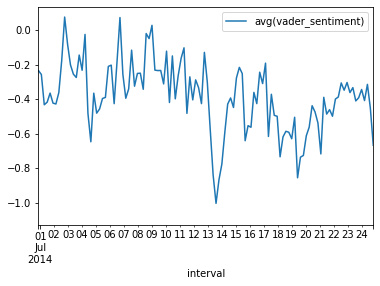

In [18]:
# Airlines shot down + fighting worsens
start_date = "2014-07-01 00:00:00"
end_date = "2014-07-25 00:00:00"

query = """CAST(created_at AS INT)
        BETWEEN unix_timestamp('{0}', 'yyyy-MM-dd HH:mm:ss')
        AND unix_timestamp('{1}', 'yyyy-MM-dd HH:mm:ss')""".format(start_date,end_date)

crimea_df = scaled_df.where(query)

interval = '5 hour'
sentiment_results_to_plot = ['vader_sentiment']

cols = ['created_at'] + sentiment_results_to_plot
results = crimea_df. \
    select(cols). \
    groupBy(F.window('created_at', interval)). \
    mean()

results. \
    withColumn('window', F.col('window').start). \
    sort('window', ascending=True). \
    withColumnRenamed('window', 'interval'). \
    toPandas(). \
    set_index('interval'). \
    plot()

plt.scatter(vader_mins_created_at, vader_mins, c='red')
for x,y in zip(vader_mins_created_at,vader_mins):
    label = "{}".format(x)

    plt.annotate(label,
                 (x,y),
                 xytext=(0,10),
                 ha='right')
plt.show()